In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm


Populating the interactive namespace from numpy and matplotlib


In [ ]:
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/'
data = pd.read_csv(path_to_data + 'WaffleDivorce.csv', sep=";", header=0)

# Q1
It is sometimes observed that the best predictor of fire risk is the presence of firefighters—States and localities with many firefighters also have more fires. Presumably firefighters do not cause fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship using multiple regression?

High divorce rates increase the pool of individuals available for remarriage, potentially increasing the marriage rate as these individuals seek new partners.

Multiple Regression model specification:

The dependent variable would be the marriage rate.

Key independent variables would include the divorce rate, along with control variables such as age, economic factors (e.g., average income, unemployment rate), demographic characteristics (e.g., median age, gender ratio), social norms (e.g., religiosity, cultural attitudes towards marriage and divorce), and legal factors (e.g., ease of getting divorced, marriage laws).

For example:
<br>
$y_i = \beta_0 + \beta_1 \times Divorcerate + \beta_2 \times economic + \beta_3 \times social$

# Q2
In the divorce data, States with high numbers of Mormons (members of The Church of Jesus Christ of Latter-day Saints, LDS) have much lower divorce rates than the regression models expected. Find a list [here](https://en.wikipedia.org/wiki/The_Church_of_Jesus_Christ_of_Latter-day_Saints_membership_statistics_(United_States)) of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

In [21]:
path_to_data = "https://raw.githubusercontent.com/newby-jay/MATH509-Winter2024-JupyterNotebooks/main/Data/WaffleDivorce.csv"
data = pd.read_csv(path_to_data, delimiter=";")

In [22]:
LDS = {
    "Location": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California",
        "Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
        "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
        "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
        "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri",
        "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio",
        "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
        "South Dakota", "Tennessee", "Texas", "Utah", "Vermont",
        "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming",
    ],
    "LDS": [
        "0.79%", "4.63%", "5.96%", "1.19%", "1.87%",
        "2.54%", "0.44%", "0.56%", "0.76%", "0.83%",
        "5.27%", "24.23%", "0.46%", "0.70%", "0.91%",
        "1.35%", "0.85%", "0.65%", "0.80%", "0.71%",
        "0.41%", "0.46%", "0.59%", "0.76%", "1.30%",
        "4.60%", "1.31%", "5.72%", "0.61%", "0.38%",
        "3.28%", "0.45%", "0.88%", "1.49%", "0.55%",
        "1.30%", "3.55%", "0.41%", "0.44%", "0.85%",
        "1.26%", "0.83%", "1.26%", "64.1%", "0.71%",
        "1.13%", "3.61%", "0.99%", "0.48%", "11.59%",
    ]
}



LDS = pd.DataFrame(LDS)

In [23]:
col_names = LDS.columns.values
col_names[0] = "Location"
LDS.columns = col_names

In [24]:
combined = pd.merge(data, LDS, on=["Location"])
combined.head(5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,LDS
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,0.79%
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,4.63%
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,5.96%
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,1.19%
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,1.87%


In [25]:
# standardize
scaled_age = (combined.MedianAgeMarriage.values - np.mean(combined.MedianAgeMarriage)) / np.std(combined.MedianAgeMarriage)
scaled_marriage = (combined.Marriage.values - np.mean(combined.Marriage)) / np.std(combined.Marriage)

In [26]:
# standardize
LDS = np.array([float(word[:-1]) for word in combined.LDS.values])
scaled_LDS = (LDS - np.mean(LDS)) / np.std(LDS)

Based on the given dataset and previous analysis, I have decided to establish a multiple regression model in which I will utilize the variables Marriage $\beta_{M}$, MedianAgeMarriage $\beta_{A}$, and LDS $\beta_{L}$.

$\mu_i = \alpha + \beta_{M}M_i + \beta_{A}A_i + \beta_L L_i  $

Where

$\alpha$ ~ $N(0,1)$

$\beta_{M}$ ~ $N(0,1)$

$\beta_{A}$ ~ $N(0,1)$

$\beta_{L}$ ~ $N(0,1)$

$\sigma$ ~ $Exp(1)$

In [27]:
with pm.Model() as Q2:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_M = pm.Normal("beta_M", mu=0, sigma=1)
    beta_A = pm.Normal("beta_A", mu=0, sigma=1)
    beta_L = pm.Normal("beta_L", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta_M * scaled_marriage + beta_A * scaled_age + beta_L * scaled_LDS
    divorce = pm.Normal("divorce", mu=mu, sigma=sigma, observed=combined.Divorce)  # likelihood of the data
    trace_Q2 = pm.sample(draws=1000, chains=4, return_inferencedata=True)
pm.summary(trace_Q2)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,9.279,0.226,8.849,9.683,0.004,0.003,3535.0,2796.0,1.0
beta_A,-1.238,0.288,-1.753,-0.675,0.005,0.004,3320.0,2677.0,1.0
beta_L,-0.561,0.243,-1.036,-0.111,0.004,0.003,3445.0,2480.0,1.0
beta_M,0.064,0.297,-0.510,0.612,0.005,0.005,3236.0,3153.0,1.0
sigma,1.480,0.170,1.193,1.812,0.003,0.002,3307.0,3038.0,1.0


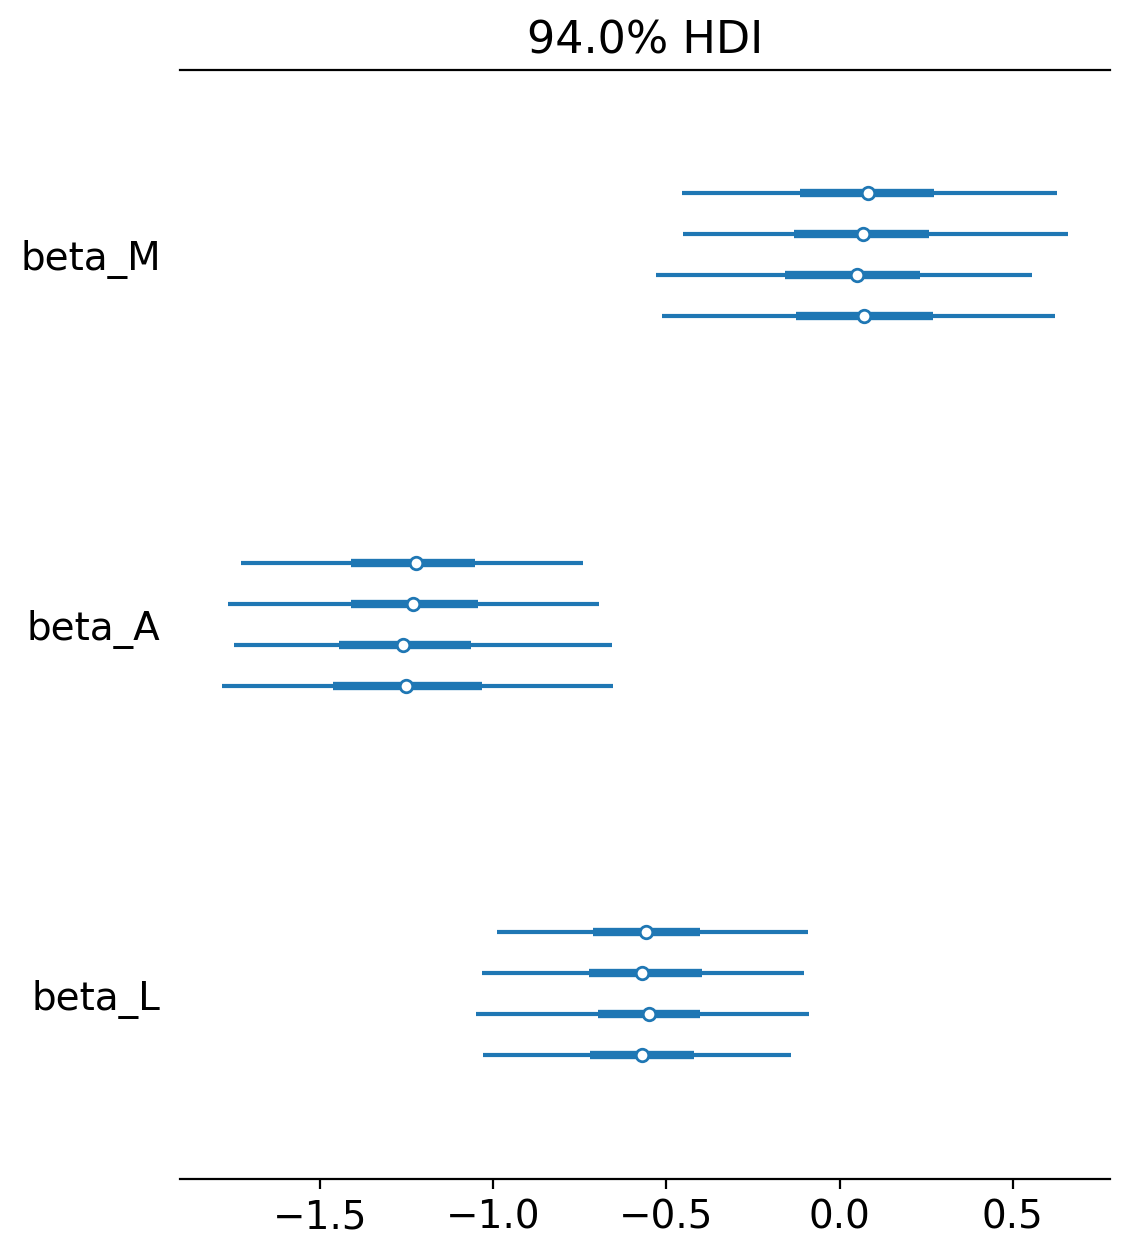

In [28]:
pm.plot_forest(trace_Q2, var_names=["beta_M", "beta_A", "beta_L"]);

We can observe a negative correlation between the percentage of LDS and divorce rate (where the value of $\beta_{L}$ is less than 0). Therefore, we can conclude that a high number of members of LDS indeed can lower the divorce rate.